# Objective
### Identify chemical compound(s) in the $Al-O-Sr-Li$ composition space as well as binary and ternary mixtures of these compounds from XRD-patterns
### This corresponds to a multi-class and multi-label classifi

# The XRD-patterns of the following compounds are considered

| class |  <div style="width:290px">Compound</div>  | Space Group|
| --- | --- | ---|
| 1 | $Al_2O_3$ | R-3cH|
| 2 | $(Al_2O_3)_{1.333}$ | Fd-3mZ|
| 3 | $Al_2O_3$ | Pna2_1|
| 4 | $Al_2O_3$ | C12/m1|
| 5 | $(Al_2O_3)_{1.333}$| I4_1/amdZ| 
| 6 | $Al_2O_3$ |Fd-3mZ|
| 7 | $(Al_2O_3)_{1.333}$| Fm-3m| 
| 8 | $Al_2O_3$ | Fm-3m|
| 9 | $AlO$ | Fm-3m|
|10 | $Al Al_{1.67}O_4$| P-4m2|
|11 | $Li_2O$| Fm-3m|
|12 | $Li_2O_2$ | P6_3/mmc|
|13 | $Li_2O_2$ | P-6|
|14 | $Li_2O$ | R-3mH|
|15 | $SrO$ | Fm-3m|
|16 | $SrO_2$ | I4/mmm|
|17 | $LiAlO_2$| P4_12_12|
|18 | $Li_5AlO_4$| PmmnZ|
|19 | $LiAl_5O_8$| P4_332|
|20 | $LiAlO_2$|R-3mH|
|21 | $LiAlO_2$|I4_1/amdZ|
|22 | $Sr(Al_2O_4)$| P12_11|
|23 | $Sr_4Al_{14}O_{25}$| Pmma|
|24 | $Sr(Al_2O_4)$|P6_3|
|25 | $Sr_9(Al_6O_{18})$| Pa-3| 
|26 | $(SrO)(Al_2O_3)_2$| C12/c1|
|27 | $Sr_7Al_{12}O_{25}$|P-3|
|28 | $Sr_{10}Al_6O_{19}$|C12/c1|
|29 | $Sr_2(Al_6O_{11})$|Pnnm|


## The *.cif - files are obtained from the Crystallography Open Database
http://www.crystallography.net/cod/

In [1]:
import os
import glob

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymatgen as pm
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from scipy import interpolate

# pymatgen is used to simulate xrd patterns from cif files
from pymatgen.analysis.diffraction.xrd import XRDCalculator

# Define Preprocessing functions
## These are used to extract peaks and augment data by randomly ...
- scaling peaks (preferred orientations, growth)
- eliminating peaks
- shifting pattern 

### This is done to simulate typical effects observed with thin films such as preferred crystallographic orientations and residual stresses

In [2]:
def find_peaks(data):
    # first savgol filter
    data_flt=savgol_filter(data,13,3)
    
    # zf are peak indices
    zf= find_peaks_cwt(data_flt[1,:], np.arange(1,10), noise_perc=0.01)    
    
    # Normalize
    y_pks=np.zeros((data.shape[1],1));
    y_pks[zf,0]=data_flt[1,zf]
    y_pks[:,0]=(y_pks[:,0]-np.min(y_pks,axis=0))/(np.max(y_pks,axis=0)-np.min(y_pks,axis=0))    
    return y_pks, zf

In [3]:
def scale_peaks(y,zf):
    scale_min = 0.33 #dont scale lower than this    
    scale_facs=np.random.uniform(scale_min,1.0,(len(zf),1))
    
    y_pks_scale = np.copy(y)
    y_pks_scale[zf] = y_pks_scale[zf]*scale_facs
        
    return y_pks_scale

In [4]:
def elim_peaks(y,zf):
    frac_elim_max = 0.35
    frac_elim = np.random.uniform(0.,frac_elim_max)
    pick_elems=np.ceil(frac_elim*len(zf)).astype(int)
    elim_indices=np.random.choice(zf,pick_elems)    
    
    y_pks_elim = np.copy(y)
    y_pks_elim[elim_indices]=0
    
    return y_pks_elim

In [5]:
def shift_peaks(y,zf):
    shift_frac = 0.05 # max shift
    shift_int = int(shift_frac * len(y))
    shift_idx = np.random.randint(-shift_int,shift_int)

    y_shifted = np.zeros(y.shape)
    for i in range(len(y)-1):
        if i+shift_idx < 0 or i+shift_idx > len(y)-1:
            continue    
        y_shifted[i+shift_idx,0]=y[i,0]    
    
    return y_shifted

# Test Preproc - functions

In [6]:
p = './foo.cif' # just a random example
structure = pm.Structure.from_file(p)
xrd = XRDCalculator() 
pattern = xrd.get_pattern(structure)
data = np.array([pattern.x, pattern.y])

In [7]:
y_pks, zf = find_peaks(data)

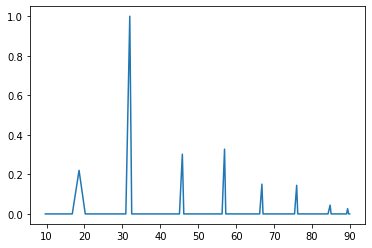

In [8]:
plt.plot(pattern.x,y_pks)
plt.show()

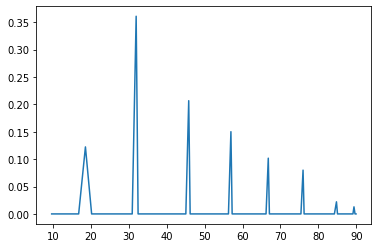

In [9]:
y_scl=scale_peaks(y_pks,zf)
plt.plot(pattern.x,y_scl)
plt.show()

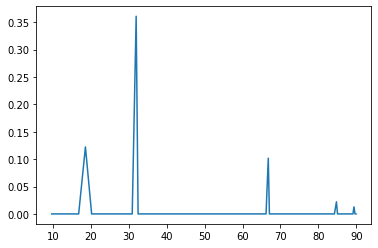

In [10]:
y_elim=elim_peaks(y_scl,zf)
plt.plot(pattern.x,y_elim)
plt.show()

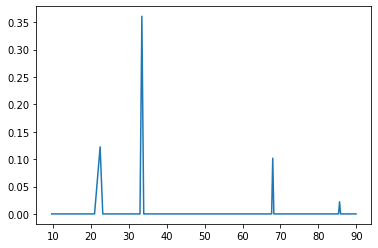

In [11]:
y_shf=shift_peaks(y_elim,zf)
plt.plot(pattern.x,y_shf)
plt.show()


# Auto-Augmentation
- randomly generate unary, binary and ternary mixtures of the compounds

In [12]:
nc = 29 # 36 classes
ny = 180 # row nr of xrd-pattern

## first create ground truth xrd pattern for every class and save for later usage

In [14]:
y_all = np.zeros((nc,ny))
xnew = np.arange(0,90,0.5) # consistent x-range for all patterns

for i in range(nc):
    curdir = './CLASSES/c'+str(i+1)+'/'
    cif = glob.glob(curdir+'*.cif')
    
    if len(cif)>0: 
        #print(f'Processing file {cif[0]}')
        structure = pm.Structure.from_file(cif[0]) #read in structure        
        xrd = XRDCalculator() 
        pattern = xrd.get_pattern(structure)        
        
        # interpolate to fixed size grid
        # do not extrapolate the data. Simply set y=0 instead to prevent 
        # creation of artificial peaks
        f=interpolate.interp1d(pattern.x,pattern.y,fill_value=(0,0),bounds_error=False)    
        ynew = ynew=f(xnew)

        #data = np.array([xnew, ynew])        
        y_all[i,:] = np.copy(ynew)
    else:
        # leave zeros for this non-existent class
        pass
        
np.savetxt('allpattern.txt',y_all,fmt='%.2f')        

# Start by Creating data for unary systems

In [15]:
m=1000 # nr of examples per class
mtotal=m*nc

In [16]:
X = np.zeros((mtotal,ny)) # input vector
Y = np.zeros((mtotal,nc)) # output vector
np.random.seed(1)

cnt=0
for i in range(nc):
    # print(f'processing iteration {i} of {m-1}')
    # pick randomly a class    
    #randclass = np.random.randint(1,nc)   
        
    y = y_all[i,:]            
    inarr = np.array([xnew,y])
    #print(i,cnt)
    y_pks, zf = find_peaks(inarr)        
    for n in range(m): # 5 examples per class
        #prepare input vec        
        y_scl=scale_peaks(y_pks,zf)
        y_elim=elim_peaks(y_scl,zf)
        y_shf=shift_peaks(y_elim,zf)

        X[cnt,:] = np.copy(y_shf[:,0])
        # prepare output vec    
        Y[cnt,i] = 1.0
        cnt = cnt+1

## Explore data: Randomly check some plots

177


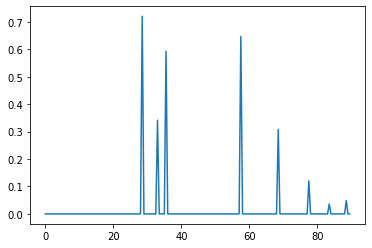

794


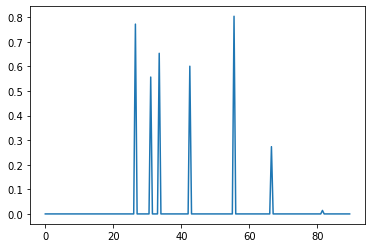

327


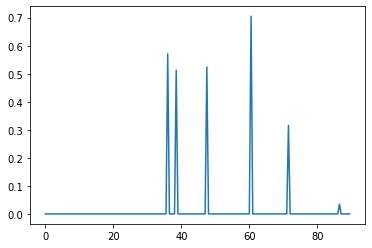

544


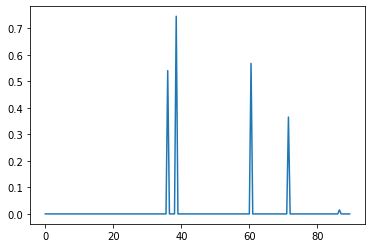

386


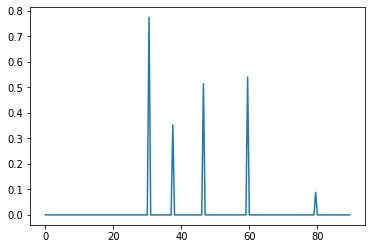

In [17]:
for i in range(5):
    foo = np.random.randint(1,m)
    print(foo)
    y = X[foo-1,:]
    plt.plot(xnew,y)
    plt.show()

# Check unary system classification with conventional ML-approaches

## SVM performance

In [18]:
from sklearn import svm,metrics
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state = 0,)

In [20]:
model=svm.SVC(kernel='rbf',class_weight='balanced',tol=1e-4,C=1.0)
clf = BinaryRelevance(model)
clf.fit(X_train,y_train,)

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred,average='micro'))
print("F1:",metrics.f1_score(y_test, y_pred,average='micro'))

Accuracy: 0.7175862068965517
Precision: 0.6732394366197183
Recall: 0.9889655172413793
F1: 0.8011173184357541


## Random forest performance

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rfc = RandomForestClassifier(bootstrap=True,
                              max_depth=None,
                              max_features='sqrt',
                              random_state=1,class_weight='balanced',
                              n_jobs=-1,)

rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred,average='micro'))
print("F1:",metrics.f1_score(y_test, y_pred,average='micro'))

Accuracy: 0.9472413793103448
Precision: 0.9713578500707214
Recall: 0.9472413793103448
F1: 0.9591480446927375


## Naive Bayes, SGD, LogRes performance

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

gnb = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, 
                    random_state=42,max_iter=1e4, class_weight='balanced',n_jobs=-1)
lr = LogisticRegression(class_weight='balanced',max_iter=1e4,n_jobs=-1)


for classifier in [gnb,sgd,lr]:
    clf=OneVsRestClassifier(classifier) # exactly the same as binary relevance
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred,average='micro'))
    print("Recall:",metrics.recall_score(y_test, y_pred,average='micro'))
    print("F1:",metrics.f1_score(y_test, y_pred,average='micro'))
    print("-------------")

# Simple ConvNet performance

In [ ]:
#os.environ['KERAS_BACKEND']='tensorflow'
from keras.models import Model
from keras.models import Sequential
import keras as K

BATCH_SIZE=128

In [ ]:
X3d = np.expand_dims(X_train, axis=-1) #conv1d expects 3d array input

In [ ]:
model = Sequential() 
wreg = K.regularizers.l2(l=1e-6) 
model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',
                          input_shape=(180,1), activation='relu', 
                          kernel_regularizer=wreg))

model.add(K.layers.Conv1D(32, 5,strides=5, 
                          padding='same', activation='relu',kernel_regularizer=wreg))

model.add(K.layers.Conv1D(16, 3,strides=3, padding='same', activation='relu',kernel_regularizer=wreg))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(512,activation='relu',kernel_regularizer=wreg))
model.add(K.layers.Dense(nc, activation='sigmoid'))


optimizer = K.optimizers.Adam()

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'],

              )

model.summary()

In [ ]:
#train_x = train_x.reshape(train_x.shape[0],n_input,1)
history = model.fit(X3d,y_train,batch_size=BATCH_SIZE, 
                    epochs=50, verbose=1,validation_split=0.1,
                   )

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Create binary system dataset

## each class should be represented equally well (the same amount of times) in the training set

### Therefore I'm using permutations instead of combinations, where tuples such as (1,1), (2,2) etc are omitted

In [ ]:
import itertools
foo=np.arange(1,nc+1) # elements 1,2,3,4,...n_classes
bin_c = list(itertools.permutations(foo,2)) # nr of binary mixtures

In [ ]:
mc = 200 # training examples per permutation
mbintotal = mc * len(bin_c)

In [ ]:
Xbin = np.zeros((mbintotal,ny)) # input vector
Ybin = np.zeros((mbintotal,nc)) # output vector

np.random.seed(1)

cnt=0
for i in range(len(bin_c)):        
    c1 = bin_c[i][0] # 1st class picked
    c2 = bin_c[i][1] # 2nd class picked
    
    y1 = y_all[c1-1,:]
    y2 = y_all[c2-1,:]
    
    inarr1 = np.array([xnew,y1])
    inarr2 = np.array([xnew,y2])
    
    y1_pks, zf1 = find_peaks(inarr1)
    y2_pks, zf2 = find_peaks(inarr2)
    
    for n in range(mc): # examples per combination
        #prepare input vec        
        y1_scl=scale_peaks(y1_pks,zf1)
        y1_elim=elim_peaks(y1_scl,zf1)
        y1_shf=shift_peaks(y1_elim,zf1)
        
        y2_scl=scale_peaks(y2_pks,zf2)
        y2_elim=elim_peaks(y2_scl,zf2)
        y2_shf=shift_peaks(y2_elim,zf2)
        
        y_merged = y1_shf + y2_shf 
        Xbin[cnt,:] = np.copy(y_merged[:,0])
        # prepare output vec    
        Ybin[cnt,c1-1] = 1.0
        Ybin[cnt,c2-1] = 1.0
        
        cnt = cnt+1

## randomly check some merged patterns

In [ ]:
for i in range(3):
    foo = np.random.randint(1,mtotal)
    print(foo,np.argwhere(Ybin[foo-1,:]==1))
    y = Xbin[foo-1,:]
    plt.plot(xnew,y)
    plt.show()

# Create data for ternary systems
## Warning: This requires an enormous amount of RAM
### For testing purposes it's recommended to reduce the number of samples per permutation $mt$

In [ ]:
mt = 50 # training examples per permutation
foo=np.arange(1,nc+1) 
ter_c = list(itertools.permutations(foo,3)
mtertotal = mt * len(ter_c)

In [ ]:
Xter = np.zeros((mtertotal,ny))  
Yter = np.zeros((mtertotal,nc)) 

np.random.seed(1)

cnt=0
for i in range(len(ter_c)):        
    c1 = ter_c[i][0] 
    c2 = ter_c[i][1] 
    c3 = ter_c[i][2] 
    
    y1 = y_all[c1-1,:]
    y2 = y_all[c2-1,:]
    y3 = y_all[c3-1,:]
    
    inarr1 = np.array([xnew,y1])
    inarr2 = np.array([xnew,y2])
    inarr3 = np.array([xnew,y3])
    
    y1_pks, zf1 = find_peaks(inarr1)
    y2_pks, zf2 = find_peaks(inarr2)
    y3_pks, zf3 = find_peaks(inarr3)
    
    for n in range(mt): # samples per permutation
        #prepare input vec        
        y1_scl=scale_peaks(y1_pks,zf1)
        y1_elim=elim_peaks(y1_scl,zf1)
        y1_shf=shift_peaks(y1_elim,zf1)
        
        y2_scl=scale_peaks(y2_pks,zf2)
        y2_elim=elim_peaks(y2_scl,zf2)
        y2_shf=shift_peaks(y2_elim,zf2)
        
        y3_scl=scale_peaks(y3_pks,zf3)
        y3_elim=elim_peaks(y3_scl,zf3)
        y3_shf=shift_peaks(y3_elim,zf3)        
        
        y_merged = y1_shf + y2_shf + y3_shf
        Xter[cnt,:] = np.copy(y_merged[:,0])
        # prepare output vec    
        Yter[cnt,c1-1] = 1.0
        Yter[cnt,c2-1] = 1.0
        Yter[cnt,c3-1] = 1.0
        
        cnt = cnt+1

## concat Xun (unary) and Xbin (binary) and Xter (ternary) training sets



In [ ]:
X=np.concatenate([Xun,Xbin,Xter],axis=0)
Y=np.concatenate([Yun,Ybin,Yter],axis=0)
X3d = np.expand_dims(X, axis=-1)  #conv1d expects 3d array input
print(X.shape)

np.save('Xall',X)
np.save('Yall',Y)

# That's it. The NN-setup and training takes place in the file 'XRD_NN.ipynb'